In [14]:
%matplotlib inline

In [2]:

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import pickle

import os
import pdb
from loren_frank_data_processing import (make_epochs_dataframe,
                                         make_neuron_dataframe)
from src.parameters import (ANIMALS, MAX_N_EXPOSURES, MIN_N_NEURONS)

from scripts.run_by_epoch import clusterless_thetasweeps
from tqdm.auto import tqdm

from scipy.stats import spearmanr, pearsonr
from scipy.signal import hilbert

In [63]:
def get_steps(Replay_traj, timeb=1):
    '''
    Get the levy exponent for replay trajectory
    Input 
        (dictionary): Replay_traj
        (int): time bin
    Output:
        (numpy array): all_steps for all ripple events
    
    '''
    #initialze an empty numpy array
    all_steps = []

    keys = Replay_traj.keys()
    for key in keys:
        #get the replay trajectory for each ripple events
        ripple_traj = Replay_traj[key]
        traj_step = np.abs(np.diff(ripple_traj[::timeb]))
        #concatenate the steps for all ripple events
        all_steps = np.concatenate((all_steps, traj_step))
    
    return all_steps

#log-log plot of the average step size against time bins
def get_exponent(Replay_traj, plot=True): 
    
    #return plt
    all_timebins = np.arange(1,20,1)
    all_avg_steps = []
    for timeb in all_timebins:
        #print(timeb)
        all_steps = get_steps(Replay_traj, timeb)
        #get the average step size for each time bin
        avg_step = np.mean(all_steps)
        all_avg_steps.append(avg_step)
    #get the slope of the log-log plot
    slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)
    
    #print('The slope of the log-log plot is %.2f'%slope)
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(3,3))
        #plot the log-log plot and add the slope as a lagend
        ax.plot(all_timebins, all_avg_steps, 'o', color='black')
        ax.plot(all_timebins, np.exp(intercept)*all_timebins**slope, 'r-', label='slope = %.2f'%slope)  
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Time bins')
        ax.set_ylabel('Average step size')
        ax.legend()
        #set both ticks to [0,10]
        ax.set_xticks([1,10])
        ax.set_yticks([1,10])
        return fig, ax, slope
    else:
        return slope
       

In [4]:
epoch_info = make_epochs_dataframe(ANIMALS)
neuron_info = make_neuron_dataframe(ANIMALS)
n_neurons = (neuron_info
                .groupby(['animal', 'day', 'epoch'])
                .neuron_id
                .agg(len)
                .rename('n_neurons')
                .to_frame())

epoch_info = epoch_info.join(n_neurons)
is_w_track = (epoch_info.environment
                .isin(['TrackA', 'TrackB', 'WTrackA', 'WTrackB']))

## Get replay and behavior levy exponent for animal bon

In [68]:
def get_run_replay_exponent(epoch_key, DATA_DIR):
    '''
    Get the run exponent for each epoch
    '''
    
    animal, day, epoch = epoch_key
    
    with open(os.path.join(DATA_DIR, 'ThetaSweepTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_data.pkl'), 'rb') as f:
        data = pickle.load(f)

    #get the Outbound run snippets
    outbound_trials = data['position_info'][data['position_info'].task=='Outbound']
    #split the outbound_trials if successive time bins are more than 10 second apart
    split_outbound_trials = np.split(outbound_trials, np.where(np.diff(outbound_trials.index) > np.timedelta64(10, 's'))[0]+1)

    #get the Inbound run snippets
    inbound_trials = data['position_info'][data['position_info'].task=='Inbound']
    #split the inbound_trials if successive time bins are more than 10 second apart
    split_inbound_trials = np.split(inbound_trials, np.where(np.diff(inbound_trials.index) > np.timedelta64(10, 's'))[0]+1)

    #save each split as a dictionary, key is the number of the split, value is the linear_distance
    #first outbound the  inbound, but save into a same dictionary
    trajectory_dict = {}
    for i in range(len(split_outbound_trials)):
        #downsample split_outbound_trials[i].linear_distance.values to 1/10
        trajectory_dict[i] = split_outbound_trials[i].linear_distance.values[::10]
    for i in range(len(split_inbound_trials)):
        trajectory_dict[i+len(split_outbound_trials)] = split_inbound_trials[i].linear_distance.values[::10]
        
    run_slope = get_exponent(trajectory_dict, plot=False)
    
    trajectory_dict_nosplit = {}
    trajectory_dict_nosplit[0] = data['position_info'].linear_distance.values[::10]
    run_slope_nosplit = get_exponent(trajectory_dict_nosplit, plot=False)
    
    #get replay 
    with open(os.path.join(DATA_DIR, 'ReplayTrajectories_all', f'{animal}_{day:02d}_{epoch:02d}_traj.pkl'), 'rb') as f:
        Replay_traj = pickle.load(f)
        
    replay_slope = get_exponent(Replay_traj, plot=False)
    
    return run_slope, run_slope_nosplit, replay_slope


In [71]:
DATA_DIR = '/media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis'

is_animal = epoch_info.index.isin(['bon'], level='animal')

valid_epochs = (is_w_track &
                (epoch_info.n_neurons > MIN_N_NEURONS) &
                (epoch_info.exposure <= MAX_N_EXPOSURES) &
                is_animal
                )

RunEXP = []
ReplayExp = []
RunEXP_nosplit = []
for epoch_key in tqdm(epoch_info[valid_epochs].index, desc='epochs'):
    animal, day, epoch = epoch_key
    print(f'Animal: {animal}, Day: {day}, Epoch: {epoch}')
    
    run_exp, run_exp_nosplit, replay_exp = get_run_replay_exponent(epoch_key, DATA_DIR)
    RunEXP.append(run_exp)
    ReplayExp.append(replay_exp)
    RunEXP_nosplit.append(run_exp_nosplit)
    
RunEXP = np.array(RunEXP)
ReplayExp = np.array(ReplayExp)
RunEXP_nosplit = np.array(RunEXP_nosplit)
    

epochs:   0%|          | 0/24 [00:00<?, ?it/s]

Animal: bon, Day: 3, Epoch: 2
Animal: bon, Day: 3, Epoch: 4
Animal: bon, Day: 3, Epoch: 6
Animal: bon, Day: 4, Epoch: 2
Animal: bon, Day: 4, Epoch: 4
Animal: bon, Day: 4, Epoch: 6
Animal: bon, Day: 5, Epoch: 2
Animal: bon, Day: 5, Epoch: 4
Animal: bon, Day: 5, Epoch: 6
Animal: bon, Day: 6, Epoch: 2
Animal: bon, Day: 6, Epoch: 4
Animal: bon, Day: 6, Epoch: 6
Animal: bon, Day: 7, Epoch: 2
Animal: bon, Day: 7, Epoch: 4
Animal: bon, Day: 7, Epoch: 6
Animal: bon, Day: 8, Epoch: 2
Animal: bon, Day: 8, Epoch: 4
Animal: bon, Day: 8, Epoch: 6
Animal: bon, Day: 9, Epoch: 2
Animal: bon, Day: 9, Epoch: 4
Animal: bon, Day: 9, Epoch: 6
Animal: bon, Day: 10, Epoch: 2
Animal: bon, Day: 10, Epoch: 4
Animal: bon, Day: 10, Epoch: 6


Text(0, 0.5, 'Replay exponent')

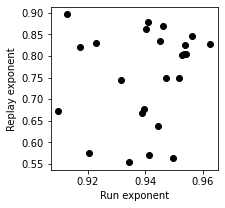

In [73]:
#plot run exponent against replay exponent
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.plot(RunEXP, ReplayExp, 'o', color='black')
ax.set_xlabel('Run exponent')
ax.set_ylabel('Replay exponent')

Text(0, 0.5, 'Replay exponent')

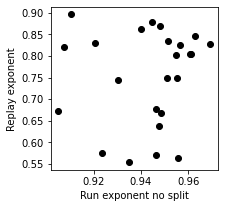

In [74]:
#plot run exponent against replay exponent
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.plot(RunEXP_nosplit, ReplayExp, 'o', color='black')
ax.set_xlabel('Run exponent no split')
ax.set_ylabel('Replay exponent')

In [72]:
RunEXP_nosplit

array([0.91052199, 0.92069141, 0.92358362, 0.90724663, 0.93027745,
       0.9049064 , 0.93993978, 0.94460851, 0.93507656, 0.94792669,
       0.95090031, 0.94626899, 0.95146708, 0.960969  , 0.95555793,
       0.95663483, 0.95482951, 0.94766569, 0.95546218, 0.96311525,
       0.94633135, 0.96109611, 0.96944176, 0.94862238])